The count of unique companies in round2 is: 90247

The count of unique companie sin companies file is: 66368

Round2 file does not have any company that is present in companies list

total no of observation in master_frame is: 114949

The mean value for funding  types venture,seed,angel,private_equity is given below: 
funding_round_type
venture           1.174895e+07
seed              7.198180e+05
angel             9.586945e+05
private_equity    7.330859e+07
Name: raised_amount_usd, dtype: float64

The most suitable funding type is:venture

Total no of investments in USA
count    1.201200e+04
sum      1.073183e+11
dtype: float64

Total no of investments in GBR
count    6.190000e+02
sum      5.365228e+09
dtype: float64

Total no of investments in IND
count    3.280000e+02
sum      2.949544e+09
dtype: float64

Sector wise breakup for USA
                                         count           sum
main_sector                                                 
Others                        

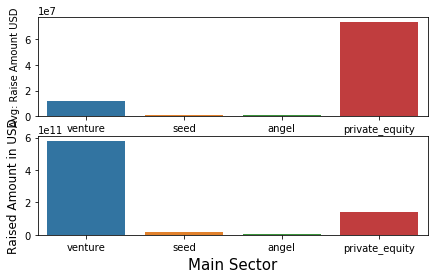

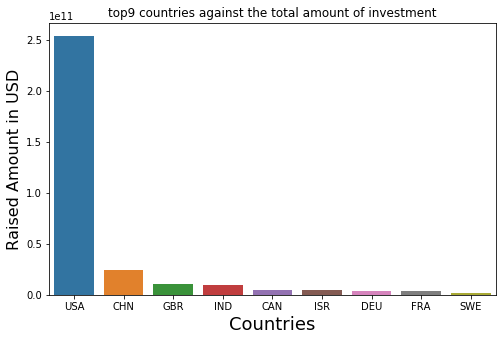

<Figure size 432x432 with 0 Axes>

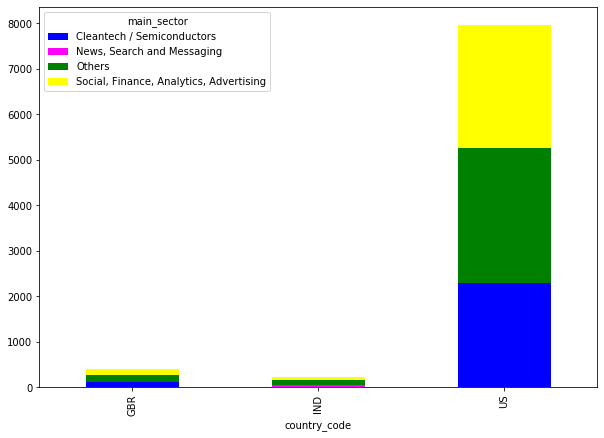

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#defining the base dir for input files to be picked from
parent_dir='C:/Users/ruchirm/Documents/UpGrad/Assignments/InvestmentAnalysis_27_April/'

#reading the txt file companies and rounds2 as CSV , with explicitly providing the seperator and the encoding
companies=pd.read_csv(parent_dir+'companies.txt',sep="\t",encoding="ISO-8859-1")
rounds2=pd.read_csv(parent_dir+'rounds2.csv',encoding="ISO-8859-1")


##########Check Point 1 : Data Cleaning###################
#Q1: How many unique companies are present in rounds2?
#Ans: getting the unique company name from column1[company_permalink] assuming this to be unqiue for a given company
#the unique will return a ndarry on which we are performing the len operation to get the count and print it

unique_companies_round2=len(rounds2.company_permalink.unique())
print("The count of unique companies in round2 is: " + str(unique_companies_round2))


#Q2:How many unique companies are present in the companies file?
#Ans: Similar to the previous quetions we will use len and unique function to get the info

unique_companies_companies=len(companies.permalink.unique())
print("\nThe count of unique companie sin companies file is: "+ str(unique_companies_companies))


#Q4: Are there any companies in the rounds2 file which are not  present in companies ? Answer Y/N.
# Ans: I am using the python inbuilt function any() to serach for each element of rounds to in companies. The function gives a boolean output,
#      so if  the o/p is true  we have common elements. In this case there are no common elements

if any(elem in companies.permalink for elem in rounds2.company_permalink):
    print("\nRounds2 list have companies that are present in companies list")
else:
    print("\nRound2 file does not have any company that is present in companies list")

#Q5: Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame ?
#Ans: I am using the pandas merge function and doing left join to get the merged df
#First I am updating the unique columns to have lower case values only without that the merge is populating NaN

companies.permalink=companies['permalink'].str.lower()
rounds2.company_permalink=rounds2.company_permalink.str.lower()
master_frame=pd.merge(rounds2,companies, how='left', left_on='company_permalink' ,right_on='permalink')
print("\ntotal no of observation in master_frame is: " + str(len(master_frame)))

###############################################################################################
##############Checkpoint 2: Funding Type Analysiss#############################################
# Using group by and mean function to find the avg of each funding type. 
#The output of df groupby is a series for which the default index will be funding type names and value will be  the means.
mean=master_frame.groupby('funding_round_type')['raised_amount_usd'].mean()

#Printing the specific mean value for required funding type
print("\nThe mean value for funding  types venture,seed,angel,private_equity is given below: ")
print(mean[['venture','seed','angel','private_equity']])

#applying range condition to get the suitable funding type names
print("\nThe most suitable funding type is:" + str(mean[mean.between(5000000,15000000)].index[0]))

###############################################################################################
##############Checkpoint 3: Country Analysis#############################################
#I have used the where caluse to filter the most suitable funding  type and then group by country , summed on the capital to get the top countries
#since ther were few NaN values in the master_frame i have also used dropna to drop these rows
top9=master_frame.where(master_frame['funding_round_type']=='venture',inplace=False).dropna().groupby('country_code').raised_amount_usd.agg(['sum']).nlargest(9,'sum')

###############################################################################################
##############Checkpoint 4: Sector Analysis 1 #############################################
#I am starting with spliting the catergory_list column and careting a new column from obtained value in same df master_frame
master_frame['primary_sector']=master_frame['category_list'].str.split('|',1).str[0]

#Reading the mapping file. It is observed that the file have null values and also there are spelling mistakes instead of 'na' '0' is used in some places
mapping=pd.read_csv(parent_dir+'mapping.csv',encoding="ISO-8859-1")

#dropping the rows with NaN values
mapping=mapping.dropna()

#fixing the string by replacing '0' in category_list column with 'na'
mapping['category_list']=mapping['category_list'].replace("0","na",regex=True)

#Now the mapping table have to be reshaped before merging. This came based on the discussion on the forum
#https://learn.upgrad.com/v/course/587/question/214365
#First we reshape => then we drop the values with 0  => we will get unique combination and hence value column is redundant=> drop teh extra column => rename to main sector
mapping = pd.melt(mapping, id_vars =['category_list'], value_vars =['Manufacturing','Automotive & Sports',
                                                              'Cleantech / Semiconductors','Entertainment',
                                                             'Health','News, Search and Messaging','Others',
                                                             'Social, Finance, Analytics, Advertising']) 
mapping = mapping[~(mapping.value == 0)]
mapping = mapping.drop('value', axis = 1)
mapping = mapping.rename(columns = {"variable":"main_sector"})

#now we merge
master_frame=pd.merge(master_frame,mapping,how='inner',left_on='primary_sector',right_on='category_list')
master_frame=master_frame.drop('category_list_y',axis=1)

###############################################################################################
##############Checkpoint 5: Sector Analysis 2 #############################################
#creating the three dfs D1,D2,D3 for USA,GBR and IND respectively
#Creating the full df is 3 steps , a)filter from master frame based on initial conditions, 
#b)find the group by aggregate values and store seprately as this is required to fill the table 5.1 also
#c) merge d1 and d1_grpby and store it in d1
d1=master_frame[(master_frame.country_code=='USA') & (master_frame.funding_round_type=='venture') &(master_frame.raised_amount_usd.between(5000000,15000000))]
d1_grpby=d1.groupby('main_sector').raised_amount_usd.agg(['count','sum']).sort_values(by='count',ascending=False)
d1=d1.merge(d1_grpby,how='inner',on='main_sector')

d2=master_frame[(master_frame.country_code=='GBR') & (master_frame.funding_round_type=='venture') &(master_frame.raised_amount_usd.between(5000000,15000000))]
d2_grpby=d2.groupby('main_sector').raised_amount_usd.agg(['count','sum']).sort_values(by='count',ascending=False)
d2=d2.merge(d2_grpby,how='inner',on='main_sector')

d3=master_frame[(master_frame.country_code=='IND') & (master_frame.funding_round_type=='venture') &(master_frame.raised_amount_usd.between(5000000,15000000))]
d3_grpby=d3.groupby('main_sector').raised_amount_usd.agg(['count','sum']).sort_values(by='count',ascending=False)
d3=d3.merge(d3_grpby,how='inner',on='main_sector')

#Below generating data for Table 5.1 ; Row 1& 2 in table 5.1
print("\nTotal no of investments in USA")
print(d1_grpby.sum()) #give the sum and count for d1 i.e USA
print("\nTotal no of investments in GBR")
print(d2_grpby.sum()) #give the sum and count for d1 i.e GBR
print("\nTotal no of investments in IND")
print(d3_grpby.sum()) #give the sum and count for d1 i.e IND

#Top sector' Row 3 - 8 in Table 5.1
print("\nSector wise breakup for USA")
print(d1_grpby) #sort the earlier grouped by based on count for USA
print("\nSector wise breakup for GBR")
print(d2_grpby)#sort the earlier grouped by based on count for GBR
print("\nSector wise breakup for IND")
print(d3_grpby) #sort the earlier grouped by based on count for IND

#Q9:company recieving highest investment in best sector Row 9 in Table 5.1
# 3 step process 
#    a. get the max investment_value in the top sector. This is required because there are multiple companies with max funded value of 15MM
#    b. get the company names from df D1,D2,D3 having max funded value
#    c. serach the companies in #3 in master_frame and get the total funding across all sector and then get the name of company with highest funding
# USA(C1)
d1_max_value_other_sector=d1[d1.main_sector=='Others']['raised_amount_usd'].max()
company_with_top_investment_d1=d1[(d1.main_sector=='Others') &(d1.raised_amount_usd==d1_max_value_other_sector)]['name']
print("\nCompany with highest funding in best sector in US")
print(master_frame[master_frame.name.isin(company_with_top_investment_d1)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

#GBR(C2)
d2_max_value_other_sector=d2[d2.main_sector=='Others']['raised_amount_usd'].max()
company_with_top_investment_d2=d2[(d2.main_sector=='Others') &(d2.raised_amount_usd==d2_max_value_other_sector)]['name']
print("\nCompany with highest funding in  best sector in GBR")
print(master_frame[master_frame.name.isin(company_with_top_investment_d2)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

#IND (C3)
d3_max_value_other_sector=d3[d3.main_sector=='Others']['raised_amount_usd'].max()
company_with_top_investment_d3=d3[(d3.main_sector=='Others') &(d3.raised_amount_usd==d3_max_value_other_sector)]['name']
print("\nCompany with highest funding in  best sector in IND")
print(master_frame[master_frame.name.isin(company_with_top_investment_d3)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

#Q10: Row 10 in Table 5.1
#The code logic remains the same only input parameter for sector will defer

# USA(C1)
d1_max_value_other_sector=d1[d1.main_sector=='Social, Finance, Analytics, Advertising']['raised_amount_usd'].max()
company_with_top_investment_d1=d1[(d1.main_sector=='Social, Finance, Analytics, Advertising') &(d1.raised_amount_usd==d1_max_value_other_sector)]['name']
print("\nCompany with highest funding in 2nd best sector in US")
print(master_frame[master_frame.name.isin(company_with_top_investment_d1)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

#GBR(C2)
d2_max_value_other_sector=d2[d2.main_sector=='Social, Finance, Analytics, Advertising']['raised_amount_usd'].max()
company_with_top_investment_d2=d2[(d2.main_sector=='Social, Finance, Analytics, Advertising') &(d2.raised_amount_usd==d2_max_value_other_sector)]['name']
print("\nCompany with highest funding in  2nd best sector in GBR")
print(master_frame[master_frame.name.isin(company_with_top_investment_d2)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

#IND (C3)
d3_max_value_other_sector=d3[d3.main_sector=='News, Search and Messaging']['raised_amount_usd'].max()
company_with_top_investment_d3=d3[(d3.main_sector=='News, Search and Messaging') &(d3.raised_amount_usd==d3_max_value_other_sector)]['name']
print("\nCompany with highest funding in  2nd best sector in IND")
print(master_frame[master_frame.name.isin(company_with_top_investment_d3)].groupby('name').raised_amount_usd.agg(['sum']).nlargest(1,'sum'))

###############################################################################################
##############Checkpoint 6: Plots #############################################
#Q1: fraction of total investment the average amount of investment in each funding type

ft_info=master_frame[master_frame.funding_round_type.isin(['venture', 'seed', 'angel', 'private_equity'])].groupby('funding_round_type').raised_amount_usd.agg(['sum'])
mean=mean.filter(['venture', 'seed', 'angel', 'private_equity'])
mean=pd.DataFrame({'Avg: Raise Amount USD': mean})

fig=plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(2,1,1)#subplot1:plot showing avg amount of funding in each of the above sector
ax2=  fig.add_subplot(2,1,2) #subplot2:  plot showing fraction of total investment
sns.barplot(x=mean.index,y='Avg: Raise Amount USD',data=mean,ax=ax1,order=['venture', 'seed', 'angel', 'private_equity'])
sns.barplot(x=ft_info.index,y='sum',data=ft_info,ax=ax2,order=['venture', 'seed', 'angel', 'private_equity'])
plt.xlabel('Main Sector', fontsize=15)
plt.ylabel('Raised Amount in USD', fontsize=12)
plt.show()

#Q2:  plot showing the top 9 countries against the total amount of investments of funding type FT.
#In schekpoint 3 we already have filtered top9 countries. Using the same df
plt.figure(figsize=(8, 5))
plt.title("top9 countries against the total amount of investment")
sns.barplot(x=top9.index,y='sum',data=top9)
plt.xlabel('Countries', fontsize=18)
plt.ylabel('Raised Amount in USD', fontsize=16)
plt.show()

#QA plot showing the number of investments in the top 3 sectors of the top 3 countries on one
#In Chekpoint 5 we already creaed countrywise dfs, reusing those and merging to get master_df
d1_grpby=d1_grpby[:3]
d1_grpby['country_code']='US'
d2_grpby=d2_grpby[:3]
d2_grpby['country_code']='GBR'
d3_grpby=d3_grpby[:3]
d3_grpby['country_code']='IND'
master_df=pd.concat([d1_grpby,d2_grpby,d3_grpby])
master_df['main_sector']=master_df.index # Creating a column named_main_sector as that is only in index

# I am going with stacked bar graph which seems to be a good visualisation for the three points in single chart.
# To do so I am going to create a pivot df=> which provides the df in a stacked form for bar plot to plot
#I am keeping country_code as the x tickers and am stacking on the main_sector. This will give me a holestic vies per country and also country breakup
# Reference article for stacked bar : https://pstblog.com/2016/10/04/stacked-charts 
pivot_master_df=master_df.pivot(index='country_code',columns='main_sector',values='count')

#sinc it's a stacked bar we should also have some colors to differentitate teh different stacks
colors = ['Blue','Magenta','Green','Yellow'] 

#creating the plot 
plt.figure(figsize=(6, 6))
pivot_master_df.plot.bar(stacked=True,color=colors,figsize=(10,7))
plt.show()







